In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


data = pd.read_csv('/content/ECO331_Data - Raw.csv')
data.head()

,Time,CPI,Unemployment,rgqoq,rgyoy,sensex,reserve,investtotal,govt_10,gdpdeflator,ipiyoy,rgyoy2,gdebt,gcons
0,Jun-04,62.59,NaN,NaN,NaN,5263.54,113754.67,NaN,5.44,68.22,NaN,NaN,NaN,NaN
1,Sep-04,64.15,NaN,2.03,NaN,5180.10,113255.67,NaN,6.20,68.84,NaN,NaN,NaN,NaN
2,Dec-04,64.57,NaN,2.02,NaN,6036.59,121044.67,NaN,6.89,69.46,NaN,9.22,NaN,NaN
3,Mar-05,64.73,NaN,1.31,NaN,6535.67,129772.67,NaN,6.63,70.36,NaN,8.38,NaN,NaN
4,Jun-05,65.10,NaN,3.57,9.22,6607.68,133742.33,NaN,7.04,70.69,NaN,9.03,NaN,NaN


In [ ]:
#Preprocessing the data

data['Date'] = pd.to_datetime(data['Time'], format='%b-%y')
data.set_index('Date', inplace=True)

data = data.drop(columns=['Time'])
data.fillna(data.mean(), inplace=True)

target_column = 'rgyoy'
features = data.drop(columns=[target_column])
target = data[target_column]


In [17]:
#Training and Prediction
results = {'Date': [], 'Actual': [], 'RF_Predicted': [], 'GB_Predicted': []}

#Without hyperparameter tuning using grid search
rf_params = {'n_estimators': 500, 'max_depth': 5}
gb_params = {'n_estimators': 500, 'learning_rate': 0.01, 'max_depth': 5}

rf = RandomForestRegressor(**rf_params)
gb = GradientBoostingRegressor(**gb_params)


for year in range(2005, 2024):
    for quarter in range(1, 5):  # For each quarter (Q1, Q2, Q3, Q4)
        # Define the training data up to the previous quarter
        train_features = features[(features.index.year < year) |
                                   ((features.index.year == year) & (features.index.quarter < quarter))]
        train_target = target[(features.index.year < year) |
                              ((features.index.year == year) & (features.index.quarter < quarter))]

        # Define the test data for the current quarter
        test_features = features[(features.index.year == year) & (features.index.quarter == quarter)]
        test_target = target[(features.index.year == year) & (features.index.quarter == quarter)].values

        if len(test_target) == 0:
            continue

        # Training the models
        rf.fit(train_features, train_target)
        gb.fit(train_features, train_target)

        # Predictions
        rf_pred = rf.predict(test_features)
        gb_pred = gb.predict(test_features)

        # Storing results
        results['Date'].append(test_features.index[0])
        results['Actual'].append(test_target[0])
        results['RF_Predicted'].append(rf_pred[0])
        results['GB_Predicted'].append(gb_pred[0])

# Converting results to DataFrame
results_df = pd.DataFrame(results)

# Calculating error metrics
rf_mse = mean_squared_error(results_df['Actual'], results_df['RF_Predicted'])
gb_mse = mean_squared_error(results_df['Actual'], results_df['GB_Predicted'])
print(f"Random Forest MSE: {rf_mse}")
print(f"Gradient Boosting MSE: {gb_mse}")




Random Forest MSE: 15.671588479661317
Gradient Boosting MSE: 16.555768710793973


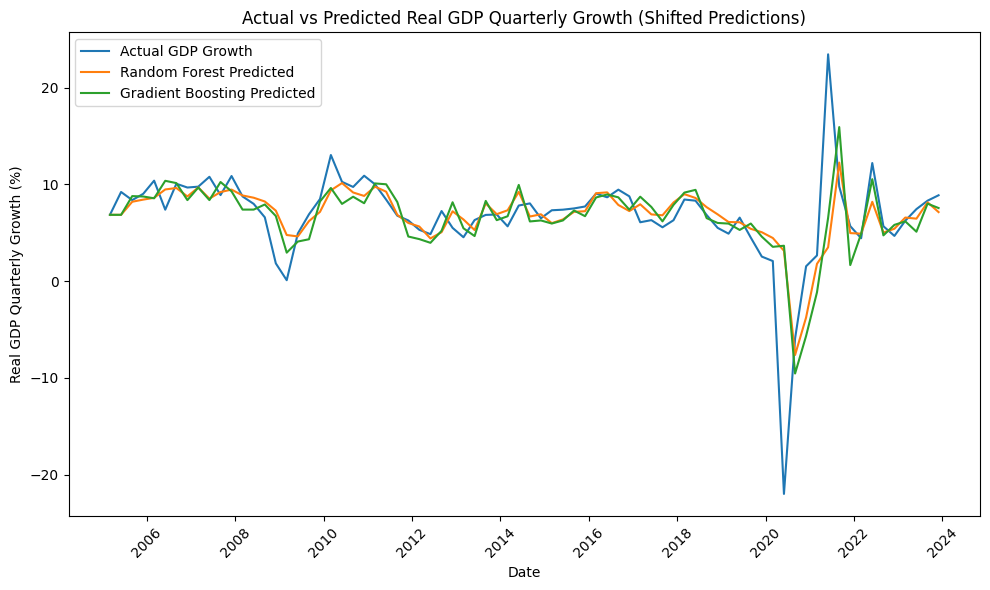

In [15]:
# Plotting actual vs. predicted GDP growth rates (shifted predictions)
plt.figure(figsize=(10, 6))
plt.plot(results_df['Date'], results_df['Actual'], label='Actual GDP Growth')
plt.plot(results_df['Date'], results_df['RF_Predicted'], label='Random Forest Predicted')
plt.plot(results_df['Date'], results_df['GB_Predicted'], label='Gradient Boosting Predicted')
plt.xlabel('Date')
plt.ylabel('Real GDP Quarterly Growth (%)')
plt.title('Actual vs Predicted Real GDP Quarterly Growth (Shifted Predictions)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
rolling_errors = {'Period': [], 'RF_MAPE': [], 'RF_RMSE': [], 'GB_MAPE': [], 'GB_RMSE': []}

# Computing MAPE and RMSE for rolling periods
for end_year in range(2005, 2025):  # From 2005-2005 up to 2005-2024
    period = f"2005-{end_year}"
    period_data = results_df[(results_df['Date'].dt.year >= 2005) & (results_df['Date'].dt.year <= end_year)]

    # Calculating MAPE and RMSE for both models
    rf_mape = mean_absolute_percentage_error(period_data['Actual'], period_data['RF_Predicted'])
    rf_rmse = mean_squared_error(period_data['Actual'], period_data['RF_Predicted'], squared=False)
    gb_mape = mean_absolute_percentage_error(period_data['Actual'], period_data['GB_Predicted'])
    gb_rmse = mean_squared_error(period_data['Actual'], period_data['GB_Predicted'], squared=False)

    # Storing the results
    rolling_errors['Period'].append(period)
    rolling_errors['RF_MAPE'].append(rf_mape)
    rolling_errors['RF_RMSE'].append(rf_rmse)
    rolling_errors['GB_MAPE'].append(gb_mape)
    rolling_errors['GB_RMSE'].append(gb_rmse)

rolling_errors_df = pd.DataFrame(rolling_errors)
rolling_errors_df.to_csv("rolling_errors.csv", index=False)
results_df.to_csv('results.csv')

In [ ]:
#Training with hyperparameter tuning
target_column = 'rgyoy'
features = data.drop(columns=[target_column])
target = data[target_column]

results = {'Date': [], 'Actual': [], 'RF_Predicted': [], 'GB_Predicted': []}

for year in range(2005, 2024):
    for quarter in range(1, 5):  # For each quarter (Q1, Q2, Q3, Q4)
        # Define the training data up to the previous quarter
        train_features = features[(features.index.year < year) |
                                   ((features.index.year == year) & (features.index.quarter < quarter))]
        train_target = target[(features.index.year < year) |
                              ((features.index.year == year) & (features.index.quarter < quarter))]

        # Define the test data for the current quarter
        test_features = features[(features.index.year == year) & (features.index.quarter == quarter)]
        test_target = target[(features.index.year == year) & (features.index.quarter == quarter)].values

        if len(test_target) == 0:
            continue

        rf = RandomForestRegressor()
        gb = GradientBoostingRegressor()

        #Set of hyperparameters to choose from
        rf_param_grid = {'n_estimators': [100, 500, 1000], 'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]}
        gb_param_grid = {'n_estimators': [100, 500, 1000], 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.3],
                         'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]}
                tscv = TimeSeriesSplit(n_splits=2)

        rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=tscv, scoring='neg_mean_squared_error')
        rf_grid_search.fit(train_features, train_target)
        rf_best = rf_grid_search.best_estimator_

        gb_grid_search = GridSearchCV(gb, gb_param_grid, cv=tscv, scoring='neg_mean_squared_error')
        gb_grid_search.fit(train_features, train_target)
        gb_best = gb_grid_search.best_estimator_

        # Predictions
        rf_pred = rf_best.predict(test_features)
        gb_pred = gb_best.predict(test_features)

        # Storing results
        results['Date'].append(test_features.index[0])
        results['Actual'].append(test_target[0])
        results['RF_Predicted'].append(rf_pred[0])
        results['GB_Predicted'].append(gb_pred[0])

results_df = pd.DataFrame(results)

# Calculating error metrics
rf_mse = mean_squared_error(results_df['Actual'], results_df['RF_Predicted'])
gb_mse = mean_squared_error(results_df['Actual'], results_df['GB_Predicted'])
print(f"Random Forest MSE: {rf_mse}")
print(f"Gradient Boosting MSE: {gb_mse}")

In [ ]:
# Plotting actual vs. predicted GDP growth rates (shifted predictions)
plt.figure(figsize=(10, 6))
plt.plot(results_df['Date'], results_df['Actual'], label='Actual GDP Growth')
plt.plot(results_df['Date'], results_df['RF_Predicted'], label='Random Forest Predicted')
plt.plot(results_df['Date'], results_df['GB_Predicted'], label='Gradient Boosting Predicted')
plt.xlabel('Date')
plt.ylabel('Real GDP Quarterly Growth (%)')
plt.title('Actual vs Predicted Real GDP Quarterly Growth (Shifted Predictions)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
rolling_errors = {'Period': [], 'RF_MAPE': [], 'RF_RMSE': [], 'GB_MAPE': [], 'GB_RMSE': []}

# Computing MAPE and RMSE for rolling periods
for end_year in range(2005, 2025):  # From 2005-2005 up to 2005-2024
    period = f"2005-{end_year}"
    period_data = results_df[(results_df['Date'].dt.year >= 2005) & (results_df['Date'].dt.year <= end_year)]

    # Calculating MAPE and RMSE for both models
    rf_mape = mean_absolute_percentage_error(period_data['Actual'], period_data['RF_Predicted'])
    rf_rmse = mean_squared_error(period_data['Actual'], period_data['RF_Predicted'], squared=False)
    gb_mape = mean_absolute_percentage_error(period_data['Actual'], period_data['GB_Predicted'])
    gb_rmse = mean_squared_error(period_data['Actual'], period_data['GB_Predicted'], squared=False)

    # Storing the results
    rolling_errors['Period'].append(period)
    rolling_errors['RF_MAPE'].append(rf_mape)
    rolling_errors['RF_RMSE'].append(rf_rmse)
    rolling_errors['GB_MAPE'].append(gb_mape)
    rolling_errors['GB_RMSE'].append(gb_rmse)

rolling_errors_df = pd.DataFrame(rolling_errors)
rolling_errors_df.to_csv("rolling_errors.csv", index=False)
results_df.to_csv('results.csv')